## Ajuste dos conjuntos de dados

In [1]:
# libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [2]:
# Vendas
df_vendas = pd.read_parquet('fato_vendas_varejo.parquet')

# Filias

df_filiais = pd.read_parquet('filiais.parquet')

# Metas Vendas

df_metas_vendas = pd.read_parquet('metas_vendas_varejo.parquet')

In [3]:
# foi identificado que a filial 1704 não existe no data set de vendas e metas de vendas
# entao optei pela remoção

filial_remover = 1704

df_vendas = df_vendas[df_vendas["codigo_filial"] != filial_remover].copy()
df_metas_vendas = df_metas_vendas[df_metas_vendas["codigo_filial"] != filial_remover].copy()

#print("df_vendas filiais:", df_vendas["codigo_filial"].nunique())
#print("df_metas_vendas filiais:", df_metas_vendas["codigo_filial"].nunique())
#print("df_filiais filiais:", df_filiais["codigo_filial"].nunique())

### Ajuste data set **Vendas**

In [4]:
df_vendas["data"] = pd.to_datetime(df_vendas["data_emissao"]).dt.normalize()

vendas_dia = (
    df_vendas
    .groupby(["codigo_filial", "data"], as_index=False)
    .agg(
        quantidade=("quantidade", "sum"),
        faturamento=("faturamento", "sum"),
        n_vendas=("codigo_documento_saida", "nunique"),  # qtd de vendas no dia
    )
    .sort_values(["codigo_filial", "data"])
    .reset_index(drop=True)
)

### Ajuste data set **Metas Vendas**

In [5]:
df_metas_vendas["data"] = pd.to_datetime(df_metas_vendas["data_meta_venda"]).dt.normalize()

df_metas_vendas = (
    df_metas_vendas
    .sort_values(["codigo_filial", "data"])
    .reset_index(drop=True)
)

### Ajuste data set **Filiais**

In [6]:
df_filiais["codigo_filial"] = df_filiais["codigo_filial"].astype(int)

## Alguma verificações de inconsistências

In [7]:
print("dtype vendas_dia:", vendas_dia["codigo_filial"].dtype)
print("dtype df_filiais:", df_filiais["codigo_filial"].dtype)
print("dtype df_filiais:", df_metas_vendas["codigo_filial"].dtype)

dtype vendas_dia: int64
dtype df_filiais: int64
dtype df_filiais: int64


In [8]:
vendas_dia

,codigo_filial,data,quantidade,faturamento,n_vendas
0,1500,2025-01-02,828.0,18077.83704,138
1,1500,2025-01-03,1107.0,29631.50298,188
2,1500,2025-01-04,597.0,14137.64100,98
3,1500,2025-01-06,975.0,21558.72465,166
4,1500,2025-01-07,969.0,25274.68470,165
...,...,...,...,...,...
42186,1887,2025-12-27,597.0,17850.20877,99
42187,1887,2025-12-28,291.0,9301.56894,62
42188,1887,2025-12-29,537.0,17140.43700,88
42189,1887,2025-12-30,735.0,16174.26540,106


In [9]:
df_metas_vendas

,codigo_filial,data_meta_venda,meta_n_med,data
0,1500,2025-01-01 03:00:00.000,0.00,2025-01-01
1,1500,2025-01-02 03:00:00.000,12732.76,2025-01-02
2,1500,2025-01-03 03:00:00.000,12732.76,2025-01-03
3,1500,2025-01-04 03:00:00.000,12732.76,2025-01-04
4,1500,2025-01-05 03:00:00.000,0.00,2025-01-05
...,...,...,...,...
42648,1887,2025-12-27 03:00:00.000,15986.05,2025-12-27
42649,1887,2025-12-28 03:00:00.000,16638.55,2025-12-28
42650,1887,2025-12-29 03:00:00.000,16312.30,2025-12-29
42651,1887,2025-12-30 03:00:00.000,14681.07,2025-12-30


In [10]:
A = vendas_dia.copy()
B = df_metas_vendas.copy()

ID_A, DT_A = "codigo_filial", "data"
ID_B, DT_B = "codigo_filial", "data"   # usa a coluna 'data' já “limpa”
META = "meta_n_med"

# 1) padroniza datas
A[DT_A] = pd.to_datetime(A[DT_A]).dt.date
B[DT_B] = pd.to_datetime(B[DT_B]).dt.date

print("Tamanhos:", len(A), len(B))
print("Filiais:", "A =", A[ID_A].nunique(), "| B =", B[ID_B].nunique())

# 2) duplicidade por chave (filial,data)
dupA = A.duplicated([ID_A, DT_A]).sum()
dupB = B.duplicated([ID_B, DT_B]).sum()
print("\nDuplicados (filial,data): A =", dupA, "| B =", dupB)

if dupA:
    print("\nExemplos duplicados A:")
    print(A[A.duplicated([ID_A, DT_A], keep=False)].sort_values([ID_A, DT_A]).head(10))

if dupB:
    print("\nExemplos duplicados B:")
    print(B[B.duplicated([ID_B, DT_B], keep=False)].sort_values([ID_B, DT_B]).head(10))

# 3) conjuntos de chaves
keysA = set(zip(A[ID_A], A[DT_A]))
keysB = set(zip(B[ID_B], B[DT_B]))

only_in_B = keysB - keysA   # meta existe, venda não existe (loja não abriu / A não registrou)
only_in_A = keysA - keysB   # venda existe, meta não existe (sab. cadastral / exceção)

print("\nChaves só no B (meta sem venda):", len(only_in_B))
print("Chaves só no A (venda sem meta):", len(only_in_A))

onlyB_df = pd.DataFrame(list(only_in_B), columns=[ID_A, DT_A])
onlyA_df = pd.DataFrame(list(only_in_A), columns=[ID_A, DT_A])

# 4) top filiais e datas que explicam a diferença
print("\nTop filiais com mais 'meta sem venda':")
print(onlyB_df.groupby(ID_A).size().sort_values(ascending=False).head(25))

print("\nTop datas com mais 'meta sem venda':")
print(onlyB_df.groupby(DT_A).size().sort_values(ascending=False).head(25))

# 5) agora: separa 'meta sem venda' em meta=0 vs meta>0 (importante!)
B_key = B[[ID_B, DT_B, META]].drop_duplicates([ID_B, DT_B])
onlyB_with_meta = onlyB_df.merge(B_key, left_on=[ID_A, DT_A], right_on=[ID_B, DT_B], how="left")

print("\nBreakdown 'meta sem venda' por meta=0 vs meta>0:")
print((onlyB_with_meta[META] == 0).value_counts().rename(index={True:"meta=0", False:"meta>0"}))

print("\nTop datas (meta=0) sem venda:")
print(onlyB_with_meta[onlyB_with_meta[META] == 0].groupby(DT_A).size().sort_values(ascending=False).head(15))

print("\nTop datas (meta>0) sem venda [mais crítico]:")
print(onlyB_with_meta[onlyB_with_meta[META] > 0].groupby(DT_A).size().sort_values(ascending=False).head(15))

# 6) merge diagnóstico (pra você “ver” o motivo em uma tabela)
diag = A.merge(
    B[[ID_B, DT_B, META]].drop_duplicates([ID_B, DT_B]),
    left_on=[ID_A, DT_A],
    right_on=[ID_B, DT_B],
    how="outer",
    indicator=True
)

print("\nDiagnóstico merge (_merge):")
print(diag["_merge"].value_counts())

print("\nExemplos: meta sem venda (right_only):")
print(diag[diag["_merge"] == "right_only"].sort_values([ID_B, DT_B]).head(10))

print("\nExemplos: venda sem meta (left_only):")
print(diag[diag["_merge"] == "left_only"].sort_values([ID_A, DT_A]).head(10))


Tamanhos: 42191 42653
Filiais: A = 124 | B = 124

Duplicados (filial,data): A = 0 | B = 0

Chaves só no B (meta sem venda): 522
Chaves só no A (venda sem meta): 60

Top filiais com mais 'meta sem venda':
codigo_filial
1749    62
1509    58
1548    57
1590    55
1500    55
1734    52
1578    40
1860    27
1854    26
1845    18
1857    18
1875    16
1617    13
1887     3
1713     2
1716     2
1545     2
1629     2
1698     2
1701     2
1656     2
1647     2
1560     1
1527     1
1635     1
dtype: int64

Top datas com mais 'meta sem venda':
data
2025-12-25    20
2025-01-01    15
2025-01-05     8
2025-01-19     8
2025-02-02     8
2025-04-13     8
2025-05-18     8
2025-08-24     8
2025-05-25     8
2025-09-28     8
2025-08-31     8
2025-09-07     8
2025-05-11     8
2025-04-06     8
2025-04-20     8
2025-04-27     8
2025-05-04     8
2025-02-23     8
2025-02-16     8
2025-02-09     8
2025-01-12     8
2025-09-21     8
2025-10-05     8
2025-10-19     8
2025-10-12     8
dtype: int64

Breakdown 'm

In [11]:
# A = vendas_dia.copy()
# B = df_metas_vendas.copy()

# A["data"] = pd.to_datetime(A["data"]).dt.date
# B["data"] = pd.to_datetime(B["data"]).dt.date

# base = A.merge(
#     B[["codigo_filial", "data", "meta_n_med"]].drop_duplicates(["codigo_filial", "data"]),
#     on=["codigo_filial", "data"],
#     how="outer",
#     indicator=True
# )

# # completa vendas ausentes com 0 (quando não existe linha no A)
# for col in ["quantidade", "faturamento", "n_vendas"]:
#     base[col] = base[col].fillna(0)

# # flags baseadas na meta
# base["flag_sem_meta"]  = base["meta_n_med"].isna()
# base["flag_meta_zero"] = base["meta_n_med"].fillna(0).eq(0)
# base["flag_meta_pos"]  = base["meta_n_med"].fillna(0).gt(0)

# # flag de venda (aqui uso n_vendas > 0 como “teve venda”; ajuste se quiser faturamento > 0)
# base["flag_teve_venda"] = base["n_vendas"].gt(0)

# # status final (prioridade: SEM_META primeiro)
# base["status"] = np.select(
#     [
#         base["flag_sem_meta"],
#         base["flag_meta_zero"],
#         base["flag_meta_pos"] & (~base["flag_teve_venda"]),
#         base["flag_meta_pos"] & (base["flag_teve_venda"]),
#     ],
#     [
#         "SEM_META",
#         "META_ZERO",
#         "META_POSITIVA_SEM_VENDA",
#         "OK",
#     ],
#     default="?"
# )

# print(base["status"].value_counts())

A = vendas_dia.copy()
B = df_metas_vendas.copy()

# padroniza datas
A["data"] = pd.to_datetime(A["data"]).dt.date
B["data"] = pd.to_datetime(B["data"]).dt.date

# merge
base = A.merge(
    B[["codigo_filial", "data", "meta_n_med"]].drop_duplicates(["codigo_filial", "data"]),
    on=["codigo_filial", "data"],
    how="outer"
)

# completa vendas ausentes com 0
for col in ["quantidade", "faturamento", "n_vendas"]:
    base[col] = base[col].fillna(0)

# cria apenas a coluna status
base["status"] = np.select(
    [
        base["meta_n_med"].isna(),
        base["meta_n_med"].eq(0),
        (base["meta_n_med"] > 0) & (base["faturamento"] == 0),
        (base["meta_n_med"] > 0) & (base["faturamento"] > 0),
    ],
    [
        "SEM_META_NaN",
        "META_ZERO",
        "META_POSITIVA_SEM_VENDA",
        "OK",
    ],
    default="?"
)

print(base["status"].value_counts())


status
OK                         41992
META_ZERO                    627
SEM_META_NaN                  60
META_POSITIVA_SEM_VENDA       34
Name: count, dtype: int64


In [12]:
base

,codigo_filial,data,quantidade,faturamento,n_vendas,meta_n_med,status
0,1500,2025-01-01,0.0,0.00000,0.0,0.00,META_ZERO
1,1500,2025-01-02,828.0,18077.83704,138.0,12732.76,OK
2,1500,2025-01-03,1107.0,29631.50298,188.0,12732.76,OK
3,1500,2025-01-04,597.0,14137.64100,98.0,12732.76,OK
4,1500,2025-01-05,0.0,0.00000,0.0,0.00,META_ZERO
...,...,...,...,...,...,...,...
42708,1887,2025-12-27,597.0,17850.20877,99.0,15986.05,OK
42709,1887,2025-12-28,291.0,9301.56894,62.0,16638.55,OK
42710,1887,2025-12-29,537.0,17140.43700,88.0,16312.30,OK
42711,1887,2025-12-30,735.0,16174.26540,106.0,14681.07,OK


In [13]:
# # linhas SEM_META (meta_n_med NaN)
# sem_meta = base[base["meta_n_med"].isna()].copy()

# print("Total SEM_META:", len(sem_meta))
# # print("Filiais com SEM_META:", sem_meta["codigo_filial"].nunique())

# # print("\nTop filiais (mais dias sem meta):")
# # print(sem_meta.groupby("codigo_filial").size().sort_values(ascending=False).head(30))

# print("\nAmostra de linhas SEM_META:")
# print(sem_meta.sort_values(["codigo_filial","data"]).head(50))

In [14]:
meta_pos_sem_venda = base[
    (base["meta_n_med"] > 0) & (base["n_vendas"] == 0)
].copy()

#print("Total META_POSITIVA_SEM_VENDA:", len(meta_pos_sem_venda))

#print("\nTop filiais:")
#print(meta_pos_sem_venda.groupby("codigo_filial").size()
#      .sort_values(ascending=False).head(20))

#print("\nTop datas:")
#print(meta_pos_sem_venda.groupby("data").size()
#      .sort_values(ascending=False).head(20))

print("\nAmostra:")
print(meta_pos_sem_venda.sort_values(["codigo_filial","data"]).head(30))



Amostra:
       codigo_filial        data  quantidade  faturamento  n_vendas  \
3549            1527  2025-09-22         0.0          0.0       0.0   
5468            1545  2025-12-25         0.0          0.0       0.0   
5725            1548  2025-09-08         0.0          0.0       0.0   
7293            1560  2025-12-25         0.0          0.0       0.0   
9185            1578  2025-03-02         0.0          0.0       0.0   
9187            1578  2025-03-04         0.0          0.0       0.0   
9483            1578  2025-12-25         0.0          0.0       0.0   
10357           1590  2025-05-18         0.0          0.0       0.0   
10448           1590  2025-08-17         0.0          0.0       0.0   
10511           1590  2025-10-19         0.0          0.0       0.0   
10574           1590  2025-12-21         0.0          0.0       0.0   
13733           1617  2025-08-17         0.0          0.0       0.0   
13740           1617  2025-08-24         0.0          0.0       0.0

Foi identificado também alguns problemas com as metas de vendas, foram identificados metas com NaN, e também há lojas que possuem metas e não tiveram vendas. \\
Para seguir com analise, foi criado uma dummy para filiais que possuem faturamento >= meta (1) e faturamento < meta. No caso, filiais com meta = 0, as linhas foram excluídas. \\


In [15]:
# 1) remove casos meta=0 e faturamento=0
base = base[~((base["meta_n_med"] == 0) & (base["faturamento"] == 0))].copy()

# 2) cria indicador: 1 se bateu meta, 0 se não bateu
# (se meta for NaN, fica NaN)
base["bateu_meta"] = np.where(
    base["meta_n_med"].isna(),
    np.nan,
    (base["faturamento"] >= base["meta_n_med"]).astype(int)
)

print(base["bateu_meta"].value_counts(dropna=False))


bateu_meta
0.0    27234
1.0    14931
NaN       60
Name: count, dtype: int64


In [16]:
base

,codigo_filial,data,quantidade,faturamento,n_vendas,meta_n_med,status,bateu_meta
1,1500,2025-01-02,828.0,18077.83704,138.0,12732.76,OK,1.0
2,1500,2025-01-03,1107.0,29631.50298,188.0,12732.76,OK,1.0
3,1500,2025-01-04,597.0,14137.64100,98.0,12732.76,OK,1.0
5,1500,2025-01-06,975.0,21558.72465,166.0,22143.91,OK,0.0
6,1500,2025-01-07,969.0,25274.68470,165.0,22143.91,OK,1.0
...,...,...,...,...,...,...,...,...
42708,1887,2025-12-27,597.0,17850.20877,99.0,15986.05,OK,1.0
42709,1887,2025-12-28,291.0,9301.56894,62.0,16638.55,OK,0.0
42710,1887,2025-12-29,537.0,17140.43700,88.0,16312.30,OK,1.0
42711,1887,2025-12-30,735.0,16174.26540,106.0,14681.07,OK,1.0


In [17]:
# VERIFICANDO A META MENSAL - SE A FILIAL BATE OU NÃO META MENSAL
dfm = base.copy()
dfm["data"] = pd.to_datetime(dfm["data"])
dfm["mes"] = dfm["data"].dt.to_period("M").astype(str)

# agrega por filial + mês (soma meta diária e faturamento)
mensal = (
    dfm.dropna(subset=["meta_n_med"])  # remove os SEM_META
       .groupby(["codigo_filial", "mes"], as_index=False)
       .agg(meta_mensal=("meta_n_med", "sum"),
            faturamento_mensal=("faturamento", "sum"))
)

# bateu a meta mensal?
mensal["bateu_meta_mensal"] = (mensal["faturamento_mensal"] >= mensal["meta_mensal"]).astype(int)

#print(mensal.head())
print("\nResumo bateu_meta_mensal:")
print(mensal["bateu_meta_mensal"].value_counts())



Resumo bateu_meta_mensal:
bateu_meta_mensal
0    1014
1     388
Name: count, dtype: int64


### Juntado os data sets após verificação

In [18]:
df_final = base.merge(df_filiais, on="codigo_filial", how="left")

In [19]:
# colunas binárias SIM/NÃO (ajuste se tiver mais)
bin_cols = ["delivery", "panvel_clinic", "estacionamento", "atendimento_24_horas"]

# transforma SIM->1, NÃO->0 (mantém NaN se existir)
for c in bin_cols:
    df_final[c] = df_final[c].astype(str).str.strip().str.upper().replace({"SIM": 1, "NÃO": 0, "NAO": 0})
    df_final[c] = pd.to_numeric(df_final[c], errors="coerce")

In [20]:
df_final

,codigo_filial,data,quantidade,faturamento,n_vendas,meta_n_med,status,bateu_meta,faixa_vida,localidade,uf,tipo_estabelecimento,delivery,metragem_area_venda,panvel_clinic,estacionamento,atendimento_24_horas
0,1500,2025-01-02,828.0,18077.83704,138.0,12732.76,OK,1.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
1,1500,2025-01-03,1107.0,29631.50298,188.0,12732.76,OK,1.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
2,1500,2025-01-04,597.0,14137.64100,98.0,12732.76,OK,1.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
3,1500,2025-01-06,975.0,21558.72465,166.0,22143.91,OK,0.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
4,1500,2025-01-07,969.0,25274.68470,165.0,22143.91,OK,1.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42220,1887,2025-12-27,597.0,17850.20877,99.0,15986.05,OK,1.0,MENOS DE 1 ANO,MARINGA,PR,SUPERMERCADO,0,632.4274,1,1,0
42221,1887,2025-12-28,291.0,9301.56894,62.0,16638.55,OK,0.0,MENOS DE 1 ANO,MARINGA,PR,SUPERMERCADO,0,632.4274,1,1,0
42222,1887,2025-12-29,537.0,17140.43700,88.0,16312.30,OK,1.0,MENOS DE 1 ANO,MARINGA,PR,SUPERMERCADO,0,632.4274,1,1,0
42223,1887,2025-12-30,735.0,16174.26540,106.0,14681.07,OK,1.0,MENOS DE 1 ANO,MARINGA,PR,SUPERMERCADO,0,632.4274,1,1,0


In [21]:
# Checagem 
print(f"Total filiais: {df_final['codigo_filial'].nunique()}")
print(f"Com estacionamento: {(df_final.drop_duplicates('codigo_filial')['estacionamento'] == 1).sum()}")
print(f"Com atendimento 24h: {(df_final.drop_duplicates('codigo_filial')['atendimento_24_horas'] == 1).sum()}")
print(f"Com Panvel Clinic: {(df_final.drop_duplicates('codigo_filial')['panvel_clinic'] == 1).sum()}")
print(f"Com delivery: {(df_final.drop_duplicates('codigo_filial')['delivery'] == 1).sum()}")



Total filiais: 124
Com estacionamento: 111
Com atendimento 24h: 4
Com Panvel Clinic: 87
Com delivery: 38


In [22]:
filiais_unicas = df_final.drop_duplicates('codigo_filial')

filiais_com_estacionamento = filiais_unicas[filiais_unicas['estacionamento'] == 1]['codigo_filial'].tolist()
print(f"Filiais COM estacionamento ({len(filiais_com_estacionamento)}): {filiais_com_estacionamento}")


# Filiais COM atendimento 24h
filiais_com_24h = filiais_unicas[filiais_unicas['atendimento_24_horas'] == 1]['codigo_filial'].tolist()
print(f"\nFiliais COM atendimento 24h ({len(filiais_com_24h)}): {filiais_com_24h}")

# Filiais COM Panvel Clinic
filiais_com_clinic = filiais_unicas[filiais_unicas['panvel_clinic'] == 1]['codigo_filial'].tolist()
print(f"\nFiliais COM Panvel Clinic ({len(filiais_com_clinic)}): {filiais_com_clinic}")

# Filiais COM delivery
filiais_com_delivery = filiais_unicas[filiais_unicas['delivery'] == 1]['codigo_filial'].tolist()
print(f"\nFiliais COM delivery ({len(filiais_com_delivery)}): {filiais_com_delivery}")

Filiais COM estacionamento (111): [1503, 1506, 1512, 1515, 1518, 1521, 1524, 1527, 1530, 1536, 1539, 1542, 1545, 1551, 1554, 1557, 1560, 1563, 1566, 1569, 1572, 1575, 1581, 1587, 1590, 1593, 1596, 1599, 1602, 1605, 1608, 1611, 1614, 1617, 1623, 1626, 1629, 1635, 1638, 1641, 1644, 1647, 1650, 1653, 1656, 1659, 1665, 1668, 1671, 1674, 1677, 1683, 1686, 1689, 1692, 1698, 1701, 1707, 1710, 1713, 1716, 1719, 1725, 1728, 1731, 1734, 1737, 1740, 1743, 1746, 1749, 1752, 1755, 1758, 1761, 1764, 1767, 1770, 1773, 1782, 1785, 1788, 1791, 1794, 1797, 1800, 1803, 1806, 1809, 1812, 1815, 1824, 1830, 1833, 1836, 1842, 1845, 1848, 1851, 1854, 1857, 1860, 1863, 1866, 1869, 1872, 1875, 1878, 1881, 1884, 1887]

Filiais COM atendimento 24h (4): [1554, 1557, 1605, 1692]

Filiais COM Panvel Clinic (87): [1503, 1509, 1512, 1518, 1524, 1536, 1545, 1557, 1563, 1566, 1590, 1593, 1596, 1599, 1602, 1611, 1614, 1626, 1635, 1638, 1641, 1644, 1653, 1656, 1659, 1662, 1665, 1677, 1683, 1686, 1695, 1698, 1710, 1719, 17

In [23]:
print("\nFaixa de vida:", filiais_unicas['faixa_vida'].value_counts(), sep='\n')
print("\nTipo estabelecimento:", filiais_unicas['tipo_estabelecimento'].value_counts(), sep='\n')


Faixa de vida:
faixa_vida
MAIS DE 3 ANOS    93
MENOS DE 1 ANO    12
ENTRE 1-2 ANOS    11
ENTRE 2-3 ANOS     8
Name: count, dtype: int64

Tipo estabelecimento:
tipo_estabelecimento
BAIRRO          76
CENTRO          38
SHOPPING         6
MALL             3
SUPERMERCADO     1
Name: count, dtype: int64


In [24]:
# 1. ANÁLISE POR TIPO DE ESTABELECIMENTO
print("ANÁLISE POR TIPO DE ESTABELECIMENTO")
print("=" * 40)
tipo_estabelecimento_analise = df_final.groupby('tipo_estabelecimento').agg({
    'n_vendas': 'mean',
    'faturamento': 'mean',
    'quantidade': 'mean',
    'codigo_filial': 'nunique'
}).round(2)

tipo_estabelecimento_analise.columns = ['Média Vendas', 'Média Faturamento', 'Média Quantidade', 'Número de Filiais']
print(tipo_estabelecimento_analise)

ANÁLISE POR TIPO DE ESTABELECIMENTO
                      Média Vendas  Média Faturamento  Média Quantidade  \
tipo_estabelecimento                                                      
BAIRRO                      124.28           26671.78            982.07   
CENTRO                      123.34           26165.47            977.31   
MALL                         77.86           17980.18            872.08   
SHOPPING                    267.85           44799.51           1715.85   
SUPERMERCADO                 72.93           11618.27            477.43   

                      Número de Filiais  
tipo_estabelecimento                     
BAIRRO                               76  
CENTRO                               38  
MALL                                  3  
SHOPPING                              6  
SUPERMERCADO                          1  


In [25]:
# 2. ANÁLISE POR PRESENÇA DE PANVEL CLINIC
print("\n\nANÁLISE POR PANVEL CLINIC")
print("=" * 40)

# garante 0/1 (SIM=1, NÃO=0)
df_final["panvel_clinic"] = (
    df_final["panvel_clinic"].astype(str).str.strip().str.upper()
    .replace({"SIM": 1, "NÃO": 0, "NAO": 0})
)
df_final["panvel_clinic"] = pd.to_numeric(df_final["panvel_clinic"], errors="coerce")

panvel_analise = df_final.groupby("panvel_clinic").agg({
    "n_vendas": "mean",
    "faturamento": "mean",
    "quantidade": "mean",
    "codigo_filial": "nunique"
}).round(2)

panvel_analise.columns = ["Média Vendas", "Média Faturamento", "Média Quantidade", "Número de Filiais"]

# troca o índice só na exibição: 0/1 -> NÃO/SIM
panvel_analise.index = panvel_analise.index.map({0: "NÃO", 1: "SIM"})

print(panvel_analise)




ANÁLISE POR PANVEL CLINIC


               Média Vendas  Média Faturamento  Média Quantidade  \
panvel_clinic                                                      
NÃO                  140.12           29403.74           1055.39   
SIM                  126.11           26311.58            998.19   

               Número de Filiais  
panvel_clinic                     
NÃO                           37  
SIM                           87  


In [26]:
df_final

,codigo_filial,data,quantidade,faturamento,n_vendas,meta_n_med,status,bateu_meta,faixa_vida,localidade,uf,tipo_estabelecimento,delivery,metragem_area_venda,panvel_clinic,estacionamento,atendimento_24_horas
0,1500,2025-01-02,828.0,18077.83704,138.0,12732.76,OK,1.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
1,1500,2025-01-03,1107.0,29631.50298,188.0,12732.76,OK,1.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
2,1500,2025-01-04,597.0,14137.64100,98.0,12732.76,OK,1.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
3,1500,2025-01-06,975.0,21558.72465,166.0,22143.91,OK,0.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
4,1500,2025-01-07,969.0,25274.68470,165.0,22143.91,OK,1.0,MAIS DE 3 ANOS,CURITIBA,PR,CENTRO,0,309.0388,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42220,1887,2025-12-27,597.0,17850.20877,99.0,15986.05,OK,1.0,MENOS DE 1 ANO,MARINGA,PR,SUPERMERCADO,0,632.4274,1,1,0
42221,1887,2025-12-28,291.0,9301.56894,62.0,16638.55,OK,0.0,MENOS DE 1 ANO,MARINGA,PR,SUPERMERCADO,0,632.4274,1,1,0
42222,1887,2025-12-29,537.0,17140.43700,88.0,16312.30,OK,1.0,MENOS DE 1 ANO,MARINGA,PR,SUPERMERCADO,0,632.4274,1,1,0
42223,1887,2025-12-30,735.0,16174.26540,106.0,14681.07,OK,1.0,MENOS DE 1 ANO,MARINGA,PR,SUPERMERCADO,0,632.4274,1,1,0


In [27]:
# 3. ANÁLISE POR TAMANHO (METRAGEM) - vamos criar categorias de tamanho
print("\n\nANÁLISE POR TAMANHO DA ÁREA DE VENDA")
print("=" * 40)

# Converter metragem para numérico
df_final['metragem_area_venda'] = pd.to_numeric(df_final['metragem_area_venda'], errors='coerce')

# Criar categorias de tamanho
bins = [0, 100, 200, 300, 400, float('inf')]
labels = ['Muito Pequeno (<100)', 'Pequeno (100-200)', 'Médio (200-300)', 'Grande (300-400)', 'Muito Grande (>400)']
df_final['categoria_tamanho'] = pd.cut(df_final['metragem_area_venda'], bins=bins, labels=labels)

tamanho_analise = df_final.groupby('categoria_tamanho').agg({
    'n_vendas': 'mean',
    'faturamento': 'mean',
    'quantidade': 'mean',
    'codigo_filial': 'nunique'
}).round(2)

tamanho_analise.columns = ['Média Vendas', 'Média Faturamento', 'Média Quantidade', 'Número de Filiais']
print(tamanho_analise)



ANÁLISE POR TAMANHO DA ÁREA DE VENDA


                     Média Vendas  Média Faturamento  Média Quantidade  \
categoria_tamanho                                                        
Médio (200-300)            243.00           36191.03           1487.13   
Grande (300-400)           156.87           26215.70           1089.56   
Muito Grande (>400)        124.65           27253.40            996.71   

                     Número de Filiais  
categoria_tamanho                       
Médio (200-300)                      2  
Grande (300-400)                    14  
Muito Grande (>400)                108  


In [28]:
# 4 ANALISE FAIXA DE VIDA 
print("ANÁLISE POR FAIXA DE VIDA ")
print("=" * 40)
faixa_de_vida_analise = df_final.groupby('faixa_vida').agg({
    'n_vendas': 'mean',
    'faturamento': 'mean',
    'quantidade': 'mean',
    'codigo_filial': 'nunique'
}).round(2)

faixa_de_vida_analise.columns = ['Média Vendas', 'Média Faturamento', 'Média Quantidade', 'Número de Filiais']
print(faixa_de_vida_analise)

ANÁLISE POR FAIXA DE VIDA 
                Média Vendas  Média Faturamento  Média Quantidade  \
faixa_vida                                                          
ENTRE 1-2 ANOS         80.27           19213.22            690.22   
ENTRE 2-3 ANOS        108.39           22604.38            842.13   
MAIS DE 3 ANOS        140.37           29056.49           1080.36   
MENOS DE 1 ANO         93.19           19539.50            820.68   

                Número de Filiais  
faixa_vida                         
ENTRE 1-2 ANOS                 11  
ENTRE 2-3 ANOS                  8  
MAIS DE 3 ANOS                 93  
MENOS DE 1 ANO                 12  


In [29]:
# 5. ANÁLISE COMBINADA (TIPO + PANVEL)
print("\n\nANÁLISE COMBINADA: TIPO DE ESTABELECIMENTO + PANVEL CLINIC")
print("=" * 60)

combinada_analise = df_final.groupby(['tipo_estabelecimento', 'panvel_clinic']).agg({
    'n_vendas': 'mean',
    'faturamento': 'mean'
}).round(2)

combinada_analise = combinada_analise.rename(index={0: 'Não', 1: 'Sim'}, level='panvel_clinic')

combinada_analise = combinada_analise.sort_index(level=['tipo_estabelecimento', 'panvel_clinic'])

print(combinada_analise)




ANÁLISE COMBINADA: TIPO DE ESTABELECIMENTO + PANVEL CLINIC
                                    n_vendas  faturamento
tipo_estabelecimento panvel_clinic                       
BAIRRO               Não              133.38     30432.20
                     Sim              119.57     24723.98
CENTRO               Não              120.06     24890.74
                     Sim              124.10     26462.20
MALL                 Não               93.07     17988.58
                     Sim               64.95     17973.06
SHOPPING             Não              226.81     33238.91
                     Sim              349.87     67904.83
SUPERMERCADO         Sim               72.93     11618.27


In [30]:
num_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()

# remove colunas que não quer na correlação
drop_cols = {"codigo_filial", "meta_n_med"}
num_cols = [c for c in num_cols if c not in drop_cols]

# 2) (opcional) detectar binárias 0/1 dentro dessas numéricas
binary_cols = [
    c for c in num_cols
    if set(df_final[c].dropna().unique()).issubset({0, 1})
]

print("Numéricas (sem codigo_filial):", num_cols)
print("Binárias (0/1):", binary_cols)

corr_pearson = df_final[num_cols].corr(method="pearson")
corr_spearman = df_final[num_cols].corr(method="spearman")


Numéricas (sem codigo_filial): ['quantidade', 'faturamento', 'n_vendas', 'bateu_meta', 'delivery', 'metragem_area_venda', 'panvel_clinic', 'estacionamento', 'atendimento_24_horas']
Binárias (0/1): ['bateu_meta', 'delivery', 'panvel_clinic', 'estacionamento', 'atendimento_24_horas']


In [31]:
print("\nPearson:")
print(corr_pearson.round(3))


Pearson:
                      quantidade  faturamento  n_vendas  bateu_meta  delivery  \
quantidade                 1.000        0.742     0.476       0.161    -0.001   
faturamento                0.742        1.000     0.616       0.220     0.070   
n_vendas                   0.476        0.616     1.000       0.181    -0.107   
bateu_meta                 0.161        0.220     0.181       1.000     0.064   
delivery                  -0.001        0.070    -0.107       0.064     1.000   
metragem_area_venda        0.113        0.283     0.076       0.011     0.227   
panvel_clinic             -0.024       -0.056    -0.097      -0.003     0.247   
estacionamento             0.050        0.075     0.069       0.010    -0.135   
atendimento_24_horas       0.093        0.109     0.201      -0.015    -0.022   

                      metragem_area_venda  panvel_clinic  estacionamento  \
quantidade                          0.113         -0.024           0.050   
faturamento                

In [32]:
print("\nCorrelação (Spearman):")
print(corr_spearman.round(3))


Correlação (Spearman):
                      quantidade  faturamento  n_vendas  bateu_meta  delivery  \
quantidade                 1.000        0.923     0.938       0.223    -0.083   
faturamento                0.923        1.000     0.866       0.291     0.060   
n_vendas                   0.938        0.866     1.000       0.158    -0.119   
bateu_meta                 0.223        0.291     0.158       1.000     0.064   
delivery                  -0.083        0.060    -0.119       0.064     1.000   
metragem_area_venda        0.056        0.131     0.016       0.019     0.210   
panvel_clinic             -0.077       -0.034    -0.100      -0.003     0.247   
estacionamento             0.094        0.112     0.073       0.010    -0.135   
atendimento_24_horas       0.180        0.174     0.186      -0.015    -0.022   

                      metragem_area_venda  panvel_clinic  estacionamento  \
quantidade                          0.056         -0.077           0.094   
faturamento  

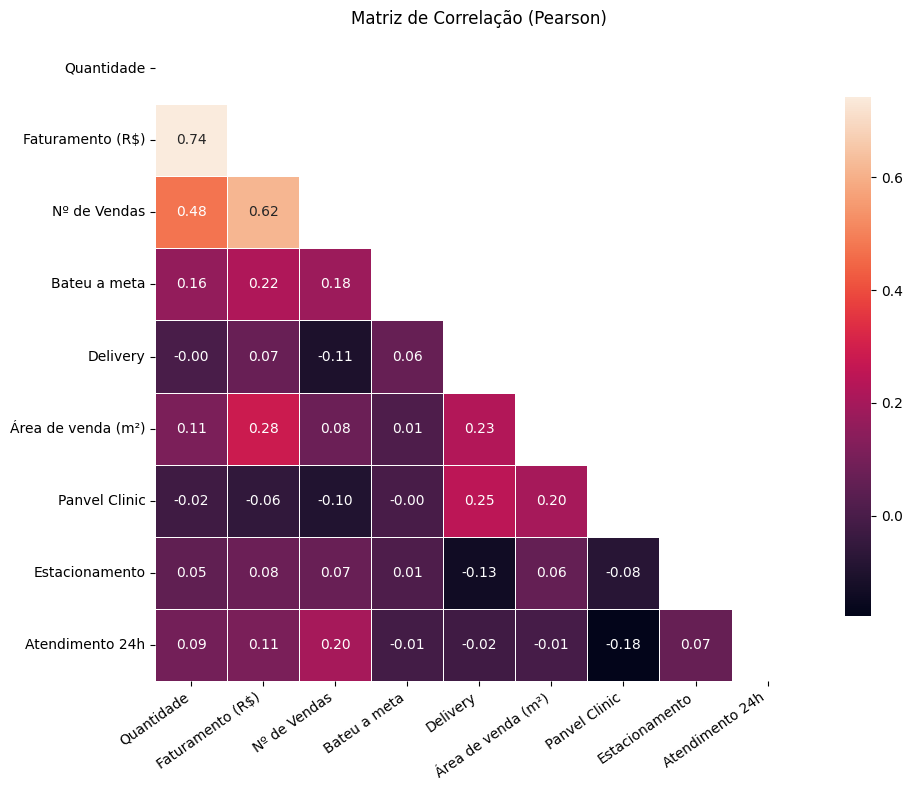

In [33]:
# Correlção 
num_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [c for c in num_cols if c not in ["codigo_filial", "meta_n_med"]]

corr = df_final[num_cols].corr(method="pearson")

pretty = {
    "quantidade": "Quantidade",
    "faturamento": "Faturamento (R$)",
    "n_vendas": "Nº de Vendas",
    "bateu_meta": "Bateu a meta",
    "delivery": "Delivery",
    "metragem_area_venda": "Área de venda (m²)",
    "panvel_clinic": "Panvel Clinic",
    "estacionamento": "Estacionamento",
    "atendimento_24_horas": "Atendimento 24h",
}

corr_plot = corr.rename(
    index=lambda x: pretty.get(x, x),
    columns=lambda x: pretty.get(x, x)
)

mask = np.triu(np.ones_like(corr_plot, dtype=bool))

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_plot,
    mask=mask,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Matriz de Correlação (Pearson)")
plt.xticks(rotation=35, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


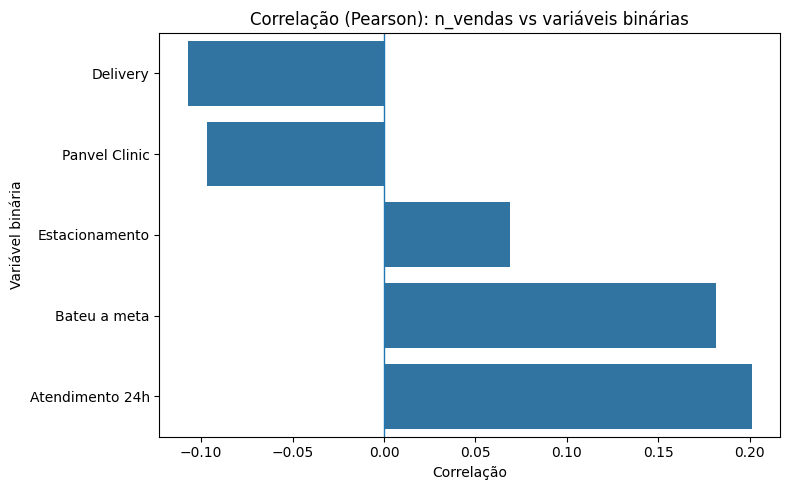

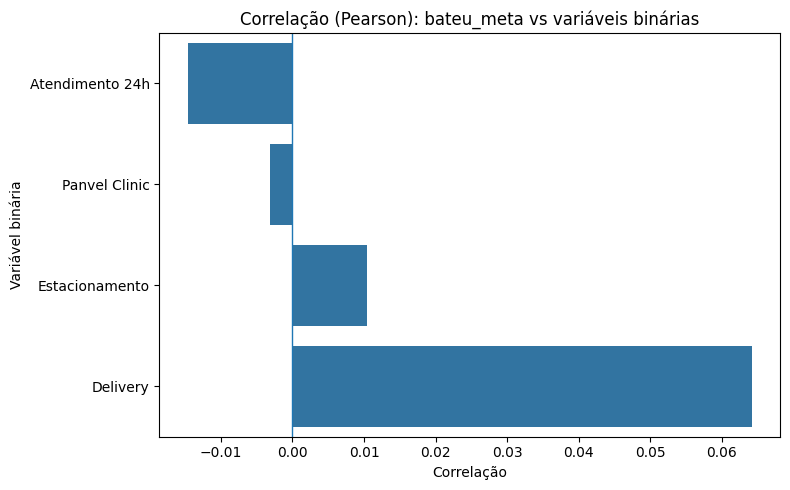

In [34]:
# --- 1) detectar colunas binárias (0/1) automaticamente
drop_cols = {"codigo_filial", "meta_n_med"}  # opcional remover meta_n_med também
binary_cols = []
for c in df_final.columns:
    if c in drop_cols:
        continue
    if pd.api.types.is_numeric_dtype(df_final[c]):
        vals = df_final[c].dropna().unique()
        if len(vals) and set(vals).issubset({0, 1, 0.0, 1.0}):
            binary_cols.append(c)

# garantir 0/1 (Int64) nas binárias
df_final[binary_cols] = df_final[binary_cols].astype("Int64")

# nomes mais bonitos (opcional)
pretty = {
    "bateu_meta": "Bateu a meta",
    "delivery": "Delivery",
    "panvel_clinic": "Panvel Clinic",
    "estacionamento": "Estacionamento",
    "atendimento_24_horas": "Atendimento 24h",
}

def nice_name(x): 
    return pretty.get(x, x)

# =========================
# GRÁFICO 1: n_vendas vs binárias
# =========================
target = "n_vendas"
corr_sales = df_final[binary_cols].corrwith(df_final[target], method="pearson").dropna()

plot1 = (
    corr_sales
    .sort_values()
    .rename(index=nice_name)
    .reset_index()
    .rename(columns={"index": "Variável binária", 0: "Correlação"})
)

plt.figure(figsize=(8, 5))
sns.barplot(data=plot1, x="Correlação", y="Variável binária")
plt.axvline(0, linewidth=1)
plt.title("Correlação (Pearson): n_vendas vs variáveis binárias")
plt.tight_layout()
plt.show()

# =========================
# GRÁFICO 2: bateu_meta vs outras binárias
# =========================
target = "bateu_meta"
other_binary = [c for c in binary_cols if c != target]

corr_meta = df_final[other_binary].corrwith(df_final[target], method="pearson").dropna()

plot2 = (
    corr_meta
    .sort_values()
    .rename(index=nice_name)
    .reset_index()
    .rename(columns={"index": "Variável binária", 0: "Correlação"})
)

plt.figure(figsize=(8, 5))
sns.barplot(data=plot2, x="Correlação", y="Variável binária")
plt.axvline(0, linewidth=1)
plt.title("Correlação (Pearson): bateu_meta vs variáveis binárias")
plt.tight_layout()
plt.show()




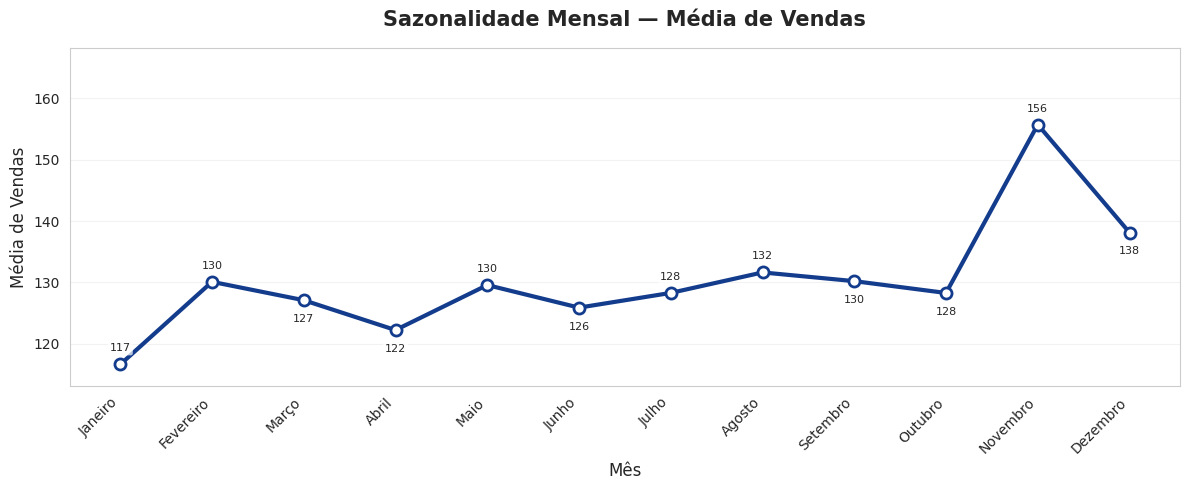

In [35]:
sns.set_style("whitegrid")

# --- garante data em datetime e cria coluna mes (1..12) se não existir ---
df_plot = df_final.copy()
df_plot["data"] = pd.to_datetime(df_plot["data"])

if "mes" not in df_plot.columns:
    df_plot["mes"] = df_plot["data"].dt.month

# --- agrupamento mensal ---
sazonalidade_mes = df_plot.groupby("mes").agg({
    "n_vendas": "mean",
    "faturamento": "mean",
    "quantidade": "mean",
    "data": "count"
}).round(2)

sazonalidade_mes.columns = ["Média Vendas", "Média Faturamento", "Média Quantidade", "Dias Registrados"]

meses_nomes = [
    "Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho",
    "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"
]
sazonalidade_mes = sazonalidade_mes.sort_index()
sazonalidade_mes.index = [meses_nomes[i-1] for i in sazonalidade_mes.index]

# --- gráfico (mesma estética do seu exemplo) ---
y = sazonalidade_mes["Média Vendas"].values
labels = sazonalidade_mes.index.tolist()
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(
    x, y,
    marker="o",
    linewidth=3,
    color="#143c8d",
    markersize=8,
    markerfacecolor="white",
    markeredgewidth=2
)

ax.set_title("Sazonalidade Mensal — Média de Vendas", fontsize=15, fontweight="bold", pad=16)
ax.set_xlabel("Mês", fontsize=12)
ax.set_ylabel("Média de Vendas", fontsize=12)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")

# Formatação do eixo Y (inteiros)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

# Grid mais suave
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

# Folga vertical
ax.set_ylim(y.min() * 0.97, y.max() * 1.08)

# Rótulos discretos alternando acima/abaixo conforme sobe/desce
for i, val in enumerate(y):
    subiu = (i == 0) or (y[i] >= y[i-1])
    dy = 8 if subiu else -10
    va = "bottom" if subiu else "top"

    ax.annotate(
        f"{val:,.0f}",
        (x[i], val),
        textcoords="offset points",
        xytext=(0, dy),
        ha="center",
        va=va,
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.70)
    )

plt.tight_layout()
plt.show()


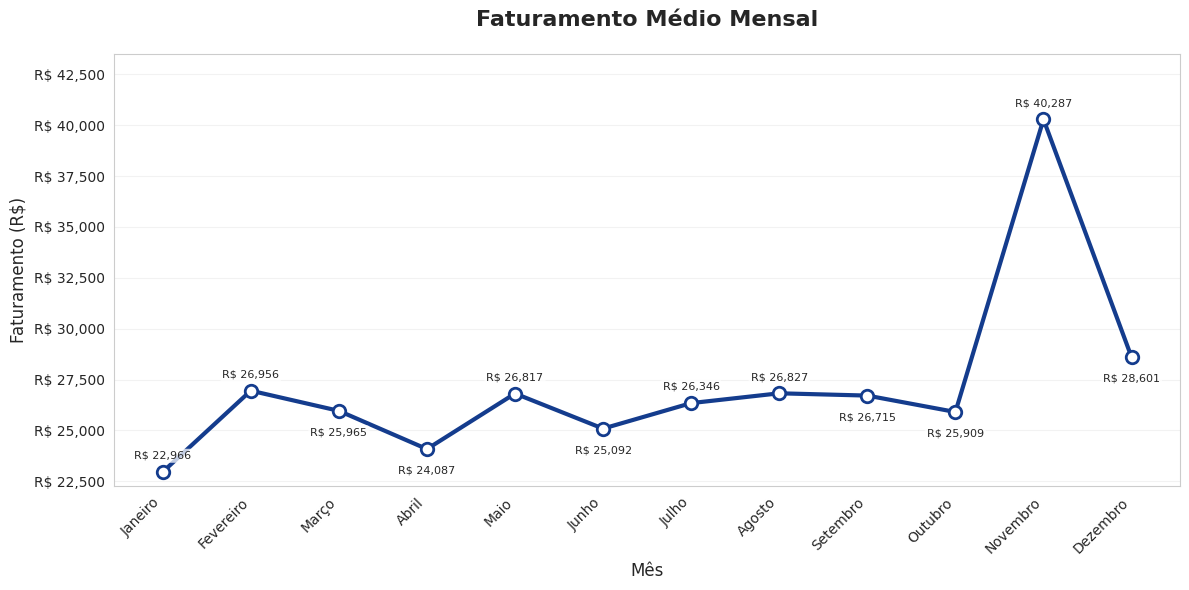

In [36]:
sns.set_style("whitegrid")

# --- garante data em datetime e cria coluna mes ---
df_plot = df_final.copy()
df_plot["data"] = pd.to_datetime(df_plot["data"])
df_plot["mes"] = df_plot["data"].dt.month

# --- faturamento médio por mês ---
sazonalidade_mes_faturamento = (
    df_plot.groupby("mes")["faturamento"]
    .mean()
    .round(2)
    .sort_index()
)

# --- nomes dos meses ---
meses_nomes = [
    "Janeiro", "Fevereiro", "Março", "Abril", "Maio", "Junho",
    "Julho", "Agosto", "Setembro", "Outubro", "Novembro", "Dezembro"
]
sazonalidade_mes_faturamento.index = [meses_nomes[i-1] for i in sazonalidade_mes_faturamento.index]

# --- gráfico ---
y = sazonalidade_mes_faturamento.values
labels = sazonalidade_mes_faturamento.index.tolist()
x = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(
    x, y,
    marker="o", linewidth=3, color="#143c8d", markersize=9,
    markerfacecolor="white", markeredgewidth=2
)

ax.set_title("Faturamento Médio Mensal", fontsize=16, fontweight="bold", pad=20)
ax.set_xlabel("Mês", fontsize=12)
ax.set_ylabel("Faturamento (R$)", fontsize=12)

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha="right")

# Formatação do eixo Y
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("R$ {x:,.0f}"))

# Folga no topo
ax.set_ylim(y.min() * 0.97, y.max() * 1.08)

# Grid suave
ax.grid(True, axis="y", alpha=0.25)
ax.grid(False, axis="x")

# Rótulos alternando acima/abaixo
for i, val in enumerate(y):
    subiu = (i == 0) or (y[i] >= y[i-1])
    dy = 8 if subiu else -12
    va = "bottom" if subiu else "top"

    texto = f"R$ {val:,.0f}"
    # alternativa em "k":
    # texto = f"R$ {val/1000:.1f}k"

    ax.annotate(
        texto,
        (x[i], val),
        textcoords="offset points",
        xytext=(0, dy),
        ha="center",
        va=va,
        fontsize=8,
        bbox=dict(boxstyle="round,pad=0.18", fc="white", ec="none", alpha=0.75)
    )

plt.tight_layout()
plt.show()


In [37]:
#df_final.to_csv("df_final_limpo.csv", index=False, encoding="utf-8")


In [39]:

import statsmodels.formula.api as smf

df = df_final.copy()

# -----------------------
# 0) Preparos básicos
# -----------------------
df["data"] = pd.to_datetime(df["data"], errors="coerce")

# controles de tempo (se você quiser ligar depois)
df["mes"] = df["data"].dt.month
df["trimestre"] = df["data"].dt.quarter
df["semana_ano"] = df["data"].dt.isocalendar().week.astype("int64")  # evita dtype "UInt32"

# (opcional) remover colunas que você NÃO quer no modelo
drop_cols = [c for c in ["codigo_filial"] if c not in df.columns]  # ensinando o padrão
# não vamos dropar aqui; codigo_filial é necessário pro cluster

# -----------------------
# 1) Detecta binárias 0/1 (e mantém só as que variam)
# -----------------------
def find_binary_cols(df):
    cols = []
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            continue
        s = df[c].dropna()
        if s.empty:
            continue
        vals = set(pd.unique(s))
        # aceita 0/1 em int/float e exige variação (len==2)
        if vals.issubset({0, 1, 0.0, 1.0}) and len(vals) == 2:
            cols.append(c)
    return cols

bin_cols = find_binary_cols(df)

# remove binárias que você NÃO quer usar como explicativas (se fizer sentido no teu caso)
# exemplo: "bateu_meta" você pode querer como outcome, não como explicativa
bin_cols = [c for c in bin_cols if c not in ["ano"]]  # se existir

print("Binárias detectadas:", bin_cols)

# -----------------------
# 2) Categóricas que existem no seu df
# -----------------------
tipo_col = "tipo_estabelecimento" if "tipo_estabelecimento" in df.columns else None
faixa_col = "faixa_vida" if "faixa_vida" in df.columns else None

# -----------------------
# 3) Função do modelo (cluster por filial)
# -----------------------
def fit_cluster_ols(df, y, add_time_controls=False):
    # checagens rápidas
    if y not in df.columns:
        raise ValueError(f"Coluna {y} não existe no dataframe.")

    # colunas base
    base_cols = ["codigo_filial", y, "metragem_area_venda"]
    if tipo_col: base_cols.append(tipo_col)
    if faixa_col: base_cols.append(faixa_col)

    # adiciona binárias (exceto o próprio y se for binário)
    used_bin = [c for c in bin_cols if c != y]
    base_cols += used_bin

    # controles de tempo (opcional)
    time_cols = []
    if add_time_controls:
        for c in ["mes", "trimestre", "semana_ano"]:
            if c in df.columns:
                time_cols.append(c)
        base_cols += time_cols

    # monta df do modelo
    dfm = df[base_cols].dropna().copy()

    # segurança: log1p exige y >= -1 (na prática, suas métricas devem ser >= 0)
    if (dfm[y] < 0).any():
        raise ValueError(f"{y} tem valores negativos. log1p(y) não é adequado sem tratamento.")

    dfm["log_y"] = np.log1p(dfm[y])

    # fórmula
    terms = ["metragem_area_venda"] + used_bin

    if tipo_col:
        terms.append(f"C({tipo_col})")
    if faixa_col:
        terms.append(f"C({faixa_col})")

    if add_time_controls:
        # você pode escolher só um (mes OU semana_ano) pra não estourar dummies
        if "mes" in dfm.columns:
            terms.append("C(mes)")
        # se preferir semana_ano, comente mes e descomente:
        # if "semana_ano" in dfm.columns:
        #     terms.append("C(semana_ano)")
        if "trimestre" in dfm.columns:
            terms.append("C(trimestre)")

    formula = "log_y ~ " + " + ".join(terms)

    model = smf.ols(formula, data=dfm).fit(
        cov_type="cluster",
        cov_kwds={"groups": dfm["codigo_filial"]}
    )

    print(f"\n=== OLS clusterizado por filial | y={y} | n={len(dfm)} | time_controls={add_time_controls} ===")
    print(model.summary().tables[1])

    # interpretação prática das binárias: approx % change = (exp(beta)-1)*100
    b = model.params.reindex(used_bin)
    p = model.pvalues.reindex(used_bin)
    pct = (np.exp(b) - 1) * 100

    out = pd.DataFrame({"beta": b, "p": p, "approx_%": pct}).sort_values("p")
    print("\n--- Binárias: efeito aproximado (%) ---")
    print(out.to_string())

    return model

# -----------------------
# 4) Rodar outcomes (sem e com controles de tempo)
# -----------------------
for y in ["faturamento", "n_vendas", "quantidade"]:
    fit_cluster_ols(df, y, add_time_controls=False)

# Se quiser controlar por sazonalidade:
# for y in ["faturamento", "n_vendas", "quantidade"]:
#     fit_cluster_ols(df, y, add_time_controls=True)

# Se quiser modelar "bateu_meta" como outcome contínuo (não é o ideal),
# dá pra rodar também, mas o correto seria Logit/Probit.
# fit_cluster_ols(df, "bateu_meta", add_time_controls=True)


Binárias detectadas: ['bateu_meta', 'delivery', 'panvel_clinic', 'estacionamento', 'atendimento_24_horas']

=== OLS clusterizado por filial | y=faturamento | n=42165 | time_controls=False ===
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   8.5801      0.206     41.625      0.000       8.176       8.984
C(tipo_estabelecimento)[T.CENTRO]           0.0128      0.064      0.199      0.842      -0.113       0.139
C(tipo_estabelecimento)[T.MALL]            -0.2467      0.088     -2.809      0.005      -0.419      -0.075
C(tipo_estabelecimento)[T.SHOPPING]         0.6634      0.154      4.300      0.000       0.361       0.966
C(tipo_estabelecimento)[T.SUPERMERCADO]    -0.8339      0.106     -7.904      0.000      -1.041      -0.627
C(faixa_vida)[T.ENTRE 2-3 ANOS]             0.3185  

In [46]:
df = df_final.copy()

# -----------------------
# 0) Preparos
# -----------------------
df["data"] = pd.to_datetime(df["data"], errors="coerce")
df["mes"] = df["data"].dt.month
df["trimestre"] = df["data"].dt.quarter
df["semana_ano"] = df["data"].dt.isocalendar().week.astype("int64")  # evita UInt

# garante bateu_meta como 0/1
if "bateu_meta" in df.columns:
    df["bateu_meta"] = df["bateu_meta"].astype("Int64")

tipo_col = "tipo_estabelecimento" if "tipo_estabelecimento" in df.columns else None
faixa_col = "faixa_vida" if "faixa_vida" in df.columns else None

# -----------------------
# 1) Binárias 0/1 (só as que variam)
# -----------------------
def find_binary_cols(df):
    cols = []
    for c in df.columns:
        if not pd.api.types.is_numeric_dtype(df[c]):
            continue
        s = df[c].dropna()
        if s.empty:
            continue
        vals = set(pd.unique(s))
        if vals.issubset({0, 1, 0.0, 1.0}) and len(vals) == 2:
            cols.append(c)
    return cols

bin_cols = find_binary_cols(df)

# binárias candidatas (tiramos bateu_meta quando ela for outcome ou quando não quiser como explicativa)
print("Binárias detectadas:", bin_cols)

# helper p/ montar termos categóricos
def cat_terms():
    terms = []
    if tipo_col:
        terms.append(f"C({tipo_col})")
    if faixa_col:
        terms.append(f"C({faixa_col})")
    return terms

# -----------------------
# 2) OLS clusterizado (para faturamento e n_vendas) SEM bateu_meta como regressor
# -----------------------
def fit_cluster_ols_no_bateu(df, y, add_time_controls=False):
    # explicativas binárias, excluindo bateu_meta
    x_bin = [c for c in bin_cols if c != "bateu_meta"]

    base_cols = ["codigo_filial", y, "metragem_area_venda"] + x_bin
    if tipo_col: base_cols.append(tipo_col)
    if faixa_col: base_cols.append(faixa_col)

    time_cols = []
    if add_time_controls:
        for c in ["mes", "trimestre"]:  # escolha simples (evita excesso de dummies)
            if c in df.columns:
                time_cols.append(c)
        base_cols += time_cols

    dfm = df[base_cols].dropna().copy()

    # log1p (evita problema com zeros)
    if (dfm[y] < 0).any():
        raise ValueError(f"{y} tem valores negativos. log1p(y) não é adequado sem tratar.")
    dfm["log_y"] = np.log1p(dfm[y])

    terms = ["metragem_area_venda"] + x_bin + cat_terms()

    if add_time_controls:
        if "mes" in dfm.columns:
            terms.append("C(mes)")
        if "trimestre" in dfm.columns:
            terms.append("C(trimestre)")

    formula = "log_y ~ " + " + ".join(terms)

    model = smf.ols(formula, data=dfm).fit(
        cov_type="cluster",
        cov_kwds={"groups": dfm["codigo_filial"]}
    )

    print(f"\n=== OLS clusterizado por filial | y={y} | n={len(dfm)} | time_controls={add_time_controls} ===")
    print(model.summary().tables[1])

    # efeitos % para binárias (aprox.)
    b = model.params.reindex(x_bin)
    p = model.pvalues.reindex(x_bin)
    pct = (np.exp(b) - 1) * 100
    out = pd.DataFrame({"beta": b, "p": p, "approx_%": pct}).sort_values("p")

    print("\n--- Binárias: efeito aproximado (%) ---")
    print(out.to_string())

    return model

# -----------------------
# 3) LOGIT clusterizado (para bateu_meta) SEM faturamento/n_vendas/quantidade como regressores
# -----------------------
def fit_cluster_logit_bateu(df, add_time_controls=False):
    y = "bateu_meta"

    # explicativas binárias excluindo a própria resposta
    x_bin = [c for c in bin_cols if c != y]

    # NÃO usar outcomes como explicativas
    exclude = {"faturamento", "n_vendas", "quantidade", "meta_n_med"}
    x_bin = [c for c in x_bin if c not in exclude]

    base_cols = ["codigo_filial", y, "metragem_area_venda"] + x_bin
    if tipo_col: base_cols.append(tipo_col)
    if faixa_col: base_cols.append(faixa_col)

    time_cols = []
    if add_time_controls:
        for c in ["mes", "trimestre"]:
            if c in df.columns:
                time_cols.append(c)
        base_cols += time_cols

    dfm = df[base_cols].dropna().copy()

    terms = ["metragem_area_venda"] + x_bin + cat_terms()

    if add_time_controls:
        if "mes" in dfm.columns:
            terms.append("C(mes)")
        if "trimestre" in dfm.columns:
            terms.append("C(trimestre)")

    formula = y + " ~ " + " + ".join(terms)

    # Logit com erros clusterizados por filial
    model = smf.logit(formula, data=dfm).fit(disp=False)
    robust = model.get_robustcov_results(cov_type="cluster", groups=dfm["codigo_filial"])

    print(f"\n=== LOGIT clusterizado por filial | y=bateu_meta | n={len(dfm)} | time_controls={add_time_controls} ===")
    print(robust.summary().tables[1])

    # Odds Ratio (OR) para binárias
    params = robust.params.reindex(x_bin)
    pvals = robust.pvalues.reindex(x_bin)
    OR = np.exp(params)

    out = pd.DataFrame({"beta": params, "p": pvals, "odds_ratio": OR}).sort_values("p")
    print("\n--- Binárias: Odds Ratio (OR) ---")
    print(out.to_string())

    return robust

# -----------------------
# 4) Rodar os 3 modelos pedidos
# -----------------------
m_fat = fit_cluster_ols_no_bateu(df, "faturamento", add_time_controls=False)
m_vendas = fit_cluster_ols_no_bateu(df, "n_vendas", add_time_controls=False)
m_bateu = fit_cluster_logit_bateu(df, add_time_controls=False)

# Se quiser com sazonalidade simples:
# m_fat = fit_cluster_ols_no_bateu(df, "faturamento", add_time_controls=True)
# m_vendas = fit_cluster_ols_no_bateu(df, "n_vendas", add_time_controls=True)
# m_bateu = fit_cluster_logit_bateu(df, add_time_controls=True)


Binárias detectadas: ['bateu_meta', 'delivery', 'panvel_clinic', 'estacionamento', 'atendimento_24_horas']

=== OLS clusterizado por filial | y=faturamento | n=42225 | time_controls=False ===
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   8.6243      0.202     42.784      0.000       8.229       9.019
C(tipo_estabelecimento)[T.CENTRO]           0.0321      0.066      0.484      0.628      -0.098       0.162
C(tipo_estabelecimento)[T.MALL]            -0.2417      0.083     -2.914      0.004      -0.404      -0.079
C(tipo_estabelecimento)[T.SHOPPING]         0.7574      0.159      4.759      0.000       0.445       1.069
C(tipo_estabelecimento)[T.SUPERMERCADO]    -0.6973      0.105     -6.638      0.000      -0.903      -0.491
C(faixa_vida)[T.ENTRE 2-3 ANOS]             0.3631  

AttributeError: 'LogitResults' object has no attribute 'get_robustcov_results'